---
## Enunciado
Para este trabajo utilizaremos un dataset de un banco, que tiene información sobre sus clientes. El dataset tiene:
- Información categórica del usuario: (`'Surname'`, `'Geography'` (donde vive), `'Gender'`, `'Age'`).
- Información bancaria: (`'Tenure'` (cuántos años lleva en el banco), `'Balance'` (cuánta plata tiene en la cuenta), `'NumOfProducts'` (cantidad de productos del banco que consume), `'HasCrCard'` (si tiene tarjeta de crédito), `'IsActiveMember'` (si es un miembro activo del banco), `'EstimatedSalary'` (cuál es su salario estimado), `'Exited'` (si hizo o no hizo churn)).

Al banco le interesa saber quienes son los clientes que tienen más chances de irse del banco para ofrecerles un paquete más competitivo y mayores beneficios.

Entonces, nuestro objetivo es entrenar modelos de aprendizaje supervisado para predecir `Exited` en función del resto de las variables. El foco del análisis debe estar puesto en predecir quienes tienen "churn" como valor de `Exited`. La métrica para evaluar performance será AUC (recuerden que pueden importarla usando `from sklearn.metrics import roc_auc_score`).


---
### Ejercicio 1
Importe el dataset a un dataframe. Asegúrese de que importa el dataset directamente desde un link de su propio drive para evitar discrepancias (bajarse el dataset desde el link compartido en el campus, subirlo a su drive, importarlo acá).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Di Tella/3er año 1S/Intro a DS/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Ejercicio 2
En este TP vamos a correr modelos de árboles y de ensambles. Piense en cuáles son las variables que deberían entrar al modelo, y que deberían ayudar a predecir el churn. Justifique su respuesta (puede ser conceptualmente o gráficamente).

Si no va a incluir las variables para ayudar a predecir, descartelas del dataset `df`.

In [ ]:
df.info()
print(df.nunique())

#Veo que Gender y Geography son categoricas, HasCrCard, IsActiveMember y Exited son binarias, y el resto son numericas.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore        

In [ ]:
# Hay variables que son identificadores. Directamente no tiene sentido incluirlas. Las descarto de base.

df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Quiero ver si entre las otras alguna podría causar overfitting. Para hacerlo voy a aprovechar mi neurodivergencia y trabajar primero con las variables numéricas,
#que son la mayoría, y voy a:
#1. hacer un test de medias por p-value (para quitar las variables irrelevantes)
#2. hacer una matriz de correlacion entre cada variable (para quitar las redundantes).

# Entonces primero veo que variable pertenece a qué categoría:

numericas = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']
catbin= ['Gender', 'Geography','HasCrCard', 'IsActiveMember']

# Voy a hacer primero el TTest sobre las variables numéricas. Explico lo que hago:

#Separo "exited" en los que efectivamente salieron y los que no. Defino un diccionario donde guardar los resultados luego.

grupo_0 = df[df['Exited'] == 0]
grupo_1 = df[df['Exited'] == 1]

resultados_ttest = {}

# Aplico el ttest en un loop que itera sobre las variables en "numéricas".

from scipy.stats import ttest_ind
for var in numericas:
    valores_0 = grupo_0[var].dropna()
    valores_1 = grupo_1[var].dropna()

    stat, pval = ttest_ind(valores_0, valores_1, equal_var=False)

    resultados_ttest[var] = {
        't_statistic': stat,
        'p_value': pval,
        'media_grupo_0': valores_0.mean(),
        'media_grupo_1': valores_1.mean()
    }

# Lo pongo en un df y las ordeno de menor a mayor (recordemos que menor es mejor)

ttest_df = pd.DataFrame.from_dict(resultados_ttest, orient='index')
ttest_df = ttest_df.sort_values(by='p_value')
print(ttest_df)

# Conclusión: Tenure y Estimated salary tienen el p_value más alto de todos (y es mayor a 0.05 que aparentemente es el cutoff) lo que significa que no podemos confiar mucho en que haya una correlación con el churn (fuente:ISLP pag 77).


                 t_statistic        p_value  media_grupo_0  media_grupo_1
Age               -30.419197  4.712727e-179      37.408389      44.837997
Balance           -12.471280   6.318664e-35   72745.296779   91108.539337
NumOfProducts       3.701998   2.185849e-04       1.544267       1.475209
CreditScore         2.634661   8.464729e-03     651.853196     645.351497
Tenure              1.384329   1.663570e-01       5.033279       4.932744
EstimatedSalary    -1.203368   2.289246e-01   99738.391772  101465.677531


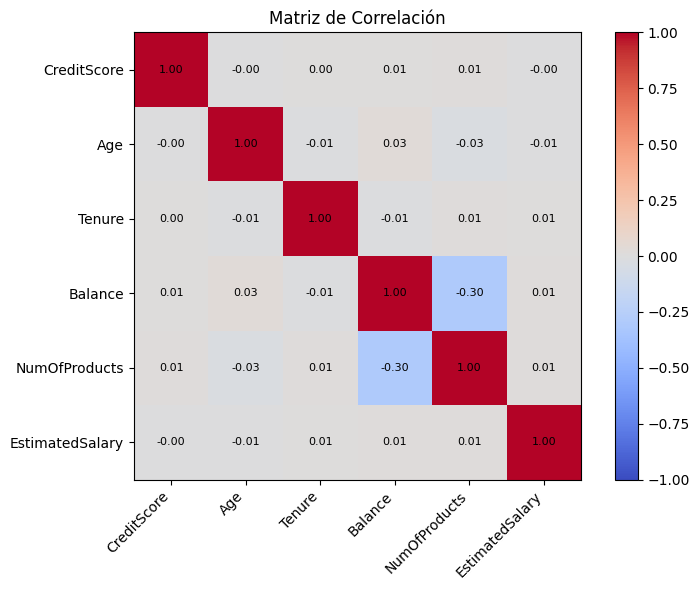

In [ ]:
#Ahora calculo la matriz de correlación con esta genialidad de pandas

matriz_corr = df[numericas].corr(method='pearson')

# Lo grafico en un heatmap, uso "imshow" que es la herramienta nativa para mostrar matrices como imagenes (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(matriz_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Pongo titulos, etiquetas, etc

ax.set_xticks(np.arange(len(numericas)))
ax.set_yticks(np.arange(len(numericas)))
ax.set_xticklabels(numericas, rotation=45, ha='right')
ax.set_yticklabels(numericas)
plt.title("Matriz de Correlación")

for i in range(len(numericas)):
    for j in range(len(numericas)):
        value = matriz_corr.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=8)

fig.colorbar(cax)
plt.tight_layout()
plt.show()

# Conclusión: como ninguna de las variables es colinear, ninguna es redundante!


In [ ]:
#Ahora veo las variables categóricas y binarias. Voy a usar un test de chi-cuadrado. La lógica es la misma que el ttest: si el p_value es alto, la descartamos.

#Lo primero que hago es calcular tablas de contingencia para cada variable (cuantos casos de exited = 0 o exited = 1 se dan por categoría de cada variable). Las necesito para el test.

tablas_cont = {}

for i in catbin:
  tabla_contingencia = pd.crosstab(df[i], df['Exited'])
  tablas_cont[i] = tabla_contingencia

#Luego hago lo mismo pero en vez de un diccionario hago una lista donde guardo los resultados del test aplicado sobre cada tabla.

from scipy import stats
resultados_chi2 = []

for var, tabla in tablas_cont.items(): #.items() hace que el diccionario sea callable, me costó banda
      chi2_stat, p_value, _, _ = stats.chi2_contingency(tabla)
      resultados_chi2.append({
        'variable': var,
        'chi-cuadrado': chi2_stat,
        'p-value': p_value
    })

#Los ordeno y los presento lindos en un df como antes.

resultados_chi2_df = pd.DataFrame(resultados_chi2)
resultados_chi2_df = resultados_chi2_df.sort_values(by='p-value', ascending=True)
resultados_chi2_df = resultados_chi2_df.reset_index(drop=True)
print(resultados_chi2_df)

         variable  chi-cuadrado       p-value
0       Geography    301.255337  3.830318e-66
1  IsActiveMember    242.985342  8.785858e-55
2          Gender    112.918571  2.248210e-26
3       HasCrCard      0.471338  4.923724e-01


In [ ]:
# La conclusión lógica es que HasCrCard no nos ayuda mucho a predecir el churn. Tenure y Estimated salary tampoco, por tener un p_value alto.
# En una primera instancia las quitamos así:

#df = df.drop(columns=['HasCrCard', 'Tenure', 'EstimatedSalary'])
#df.head()

# Pero nos acabamos de dar cuenta de que en futuros ejercicios se nos pide hacer cosas con random forest y arboles de decision. Si las quitamos posiblemente perdamos valor al final del analisis.
# La decisión es quitar unicamente los identificadores y mantener estas tres variables.
# En el futuro nos aseguramos de comparar con lo que encontramos en esta sección.

print(df.shape)
df.head()


(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


---
### Ejercicio 3
Cree un validation-set con 1100 observaciones elegidas al azar (con una seed fijada en 1234 para garantizar reproducibilidad). Llámelo `df_val`.

In [ ]:
df_val = df.sample(
    n=1100,
    random_state=1234)
df_val.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2374,639,Spain,Male,29,4,133434.57,2,1,0,97983.44,0
1784,658,France,Male,36,8,174060.46,1,1,1,94925.62,0
6301,766,Germany,Female,45,6,97652.96,1,1,0,127332.33,0
1600,517,France,Male,28,2,115062.61,1,1,0,179056.23,0
7920,714,France,Male,34,5,141173.03,1,0,1,98896.06,0


---
### Ejercicio 4
Cree un test-set con 1100 observaciones elegidas al azar (que no deben haber sido elegidas en el punto 2 como parte del conjunto del validation set). Fije una seed de 1234 para garantizar reproducibilidad. Llámelo `df_test`.

In [ ]:
df_separado = df.drop(df_val.index)
df_test = df_separado.sample(
    n=1100,
    random_state=1234)

df_test.head() #Me aseguro de que no se haya borrado el índice

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
252,681,France,Female,79,0,0.00,2,0,1,170968.99,0
7641,797,France,Male,31,9,0.00,2,1,1,24748.89,0
9010,645,Germany,Female,59,8,121669.93,2,0,0,91.75,1
9371,641,France,Male,31,9,112494.99,1,1,1,32231.60,0
7375,639,France,Male,77,6,80926.02,2,1,1,55829.25,0


---
### Ejercicio 5
Cree un training-set que sea igual a churn_data pero no incluya las observaciones extraídas tanto para el validation set como para el test set. Llámelo `df_train`.

Aporte una validación cuantitativa donde se observe que las filas del dataset de train, validation y test no están repetidas entre sí. Si en su validación no se observan los resultados correctos, repita el ejercicio 3 y 4 hasta lograr que los tres datasets estén bien separados de forma aleatoria (el resto de los ejercicios van a depender de que esto esté bien hecho).

In [ ]:
df_train = df_separado.drop(df_test.index)
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0


In [ ]:
#Ahora queremos validar que los tres sets sean disjuntos. Habiendo cursado mate V, esto es equivalente a que la intersección sea nula.
#Primero corroboramos que los tamaños de los dfs sean correctos:

print("Tamaño de df_train:", df_train.shape)
print("Tamaño de df_val:", df_val.shape)
print("Tamaño de df_test:", df_test.shape)
total_filas = len(df_train) + len(df_val) + len(df_test)
print('Cantidad total de filas:', total_filas)

Tamaño de df_train: (7800, 11)
Tamaño de df_val: (1100, 11)
Tamaño de df_test: (1100, 11)
Cantidad total de filas: 10000


In [ ]:
#Luego, comprobamos que no haya filas repetidas en los dfs. Para hacerlo, vamos a ver si los índices se repiten entre ellos.

train_indices = set(df_train.index)
val_indices = set(df_val.index)
test_indices = set(df_test.index)

#Vemos si los conjuntos de índices se intersectan
interseccion_train_val = len(train_indices.intersection(val_indices))
interseccion_train_test = len(train_indices.intersection(test_indices))
interseccion_val_test = len(val_indices.intersection(test_indices))

#Si la intersección es 0, significa que los índices no se repiten entre los dfs

print(f'La intersección entre los índices de df_train y df_val es: {interseccion_train_val}')
print(f'La intersección entre los índices de df_train y df_test es: {interseccion_train_test}')
print(f'La intersección entre los índices de df_val y df_test es: {interseccion_val_test}')

La intersección entre los índices de df_train y df_val es: 0
La intersección entre los índices de df_train y df_test es: 0
La intersección entre los índices de df_val y df_test es: 0


---
### Ejercicio 6
Si desea incluir variables categóricas dentro del modelo, deberá transformarlas utilizando One Hot Encoding antes de empezar.

Validando el modelo mediante k-fold cross validation con 10
folds evalúe cuál es la performance (en términos de auc-roc) de un árbol de decisión (de la librería scikit-learn) que utiliza los hiperparámetros default, sobre el dataset `df_train`.

Fije el random_state en 1234 para que los resultados sean reproducibles.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

#Armamos el preprocessor para transformar las variables categóricas. Hacemos una lista con las features categóricas porque al principio estaban mezcladas con las binarias,
# y agregamos las binarias a las numéricas

categoricas = ['Gender', 'Geography']
num_bin = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary','HasCrCard', 'IsActiveMember']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
    ('num', 'passthrough', num_bin)
])

#Armamos el modelo

arbol = DecisionTreeClassifier(random_state=1234)

#Hacemos un pipeline para ordenar el proceso

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', arbol)
])

#Dividmos entre x train e y train
X_train = df_train.drop('Exited', axis=1)
y_train = df_train['Exited']

#Usamos el cross_val_score sacado de la documentación de scikit para evaluar la performance
auc_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')

print(f"AUC scores para cada uno de los 10 folds:\n{auc_scores}\n")
print(f"AUC promedio:{sum(auc_scores)/len(auc_scores)}")

AUC scores para cada uno de los 10 folds:
[0.70949677 0.66425806 0.71912258 0.70136774 0.71507097 0.67147436
 0.62980769 0.72035256 0.69310897 0.64903846]

AUC promedio:0.687309818031431


---
### Ejercicio 7
Lleve adelante un experimento en donde entrenando con el dataset creado en el ejercicio 5 y validando con el dataset creado en el ejercicio 3, entrene árboles de decisión con todas las combinaciones posible de:
- max_depth entre 1 y 10.
- min_samples_split entre 2 y 11,
- min_samples_leaf entre 1 y 10.

En total, debería tener 1000 combinaciones de hiperparámetros posibles.

En cada paso evalúe el AUC, tanto de entrenamiento como de validación.

El resultado de este ejercicio debería ser un dataframe que se llame `dtree_exp` que tiene que tener las siguientes 5 columnas:
- max_depth,
- min_samples_split,
- min_samples_leaf,
- auc_training
- auc_validation
- experiment_id (`dtree_exp['experiment_id'] = [f'experiment_{i}' for i in range(len(dtree_exp))]`)


**Este dataframe debería tener 1000 filas.**

Nota: NO puede usar GridSearchCV del paquete scikit-learn.

In [ ]:
from sklearn.metrics import roc_auc_score

#Preparamos los dfs que vamos a necesitar
X_train = df_train.drop('Exited', axis=1)
y_train = df_train['Exited']
X_val = df_val.drop('Exited', axis=1)
y_val = df_val['Exited']

#Transformamos las variables categóricas usando el procesador que armamos en el ejercicio anterior. Lo aplicamos solo sobre el X train para evitar data leakage.
preprocessor.fit(X_train)

X_train_procesado = preprocessor.transform(X_train)
X_val_procesado = preprocessor.transform(X_val)

#Entrenamos los árboles iterando sobre los distintos hiperparámetros y evaluamos la performance
max_depth_range = range(1, 11)
min_samples_split_range = range(2, 12)
min_samples_leaf_range = range(1, 11)

resultados = []

for depth in max_depth_range:
    for split in min_samples_split_range:
        for leaf in min_samples_leaf_range:
            modelo = DecisionTreeClassifier(
                max_depth=depth,
                min_samples_split=split,
                min_samples_leaf=leaf,
                random_state=1234
            )
            modelo.fit(X_train_procesado, y_train)

            y_train_probabilidad = modelo.predict_proba(X_train_procesado)[:, 1]
            y_val_probabilidad = modelo.predict_proba(X_val_procesado)[:, 1]

            auc_training = roc_auc_score(y_train, y_train_probabilidad)
            auc_validation = roc_auc_score(y_val, y_val_probabilidad)

            resultados.append({
                'max_depth': depth,
                'min_samples_split': split,
                'min_samples_leaf': leaf,
                'auc_training': auc_training,
                'auc_validation': auc_validation
            })

dtree_exp = pd.DataFrame(resultados)
dtree_exp['experiment_id'] = [f'experiment_{i}' for i in range(len(dtree_exp))]
columnas_ordenadas = ['experiment_id', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'auc_training', 'auc_validation']
dtree_exp = dtree_exp[columnas_ordenadas]


print(f"Filas totales del df: {len(dtree_exp)}")
print(dtree_exp.head())

Filas totales del df: 1000
  experiment_id  max_depth  min_samples_split  min_samples_leaf  auc_training  \
0  experiment_0          1                  2                 1      0.689167   
1  experiment_1          1                  2                 2      0.689167   
2  experiment_2          1                  2                 3      0.689167   
3  experiment_3          1                  2                 4      0.689167   
4  experiment_4          1                  2                 5      0.689167   

   auc_validation  
0        0.691956  
1        0.691956  
2        0.691956  
3        0.691956  
4        0.691956  


### Ejercicio 8
Identifique la mejor combinación de hiperparámetros según el experimento. En caso que más de una combinación de hiperparámetros diera el máximo valor de AUC en validación, elija cualquiera de las mismas.

Obtenga la mejor combinación de hiperparámetros como un diccionario (keys: nombre de hp, valor: valor de hp) y guárdela en la variable `best_combination_hp_dtree`.

Responda las siguientes preguntas:
- ¿Qué tanto varía la AUC entre los distintos experimentos?
- ¿Cuál es el hiperparámetro que más hace variar la AUC?
- Más allá de cuál es la combinación que trajo la mayor AUC, ¿por qué cree que podría ser esa combinación la que tiene una mejor performance? Justifique su respuesta.

In [ ]:
#Veamos cuál es la mejor combinación de hiperparámetros. Para eso, veamos qué experimento arrojó el máximo AUC en validación

maximo_auc = dtree_exp['auc_validation'].max()
dtree_mejor_comb = dtree_exp.loc[dtree_exp['auc_validation'] == maximo_auc]
dtree_mejor_comb

,experiment_id,max_depth,min_samples_split,min_samples_leaf,auc_training,auc_validation
594,experiment_594,6,11,5,0.863454,0.84426


In [ ]:
best_combination_hp_dtree = {
    'max_depth': int(dtree_mejor_comb['max_depth'].iloc[0]),
    'min_samples_split': int(dtree_mejor_comb['min_samples_split'].iloc[0]),
    'min_samples_leaf': int(dtree_mejor_comb['min_samples_leaf'].iloc[0]),
    }

best_combination_hp_dtree

{'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 5}

In [ ]:
#Ahora contestemos las otras preguntas.

dtree_exp['auc_validation'].describe()

,auc_validation
count,1000.000000
mean,0.804025
std,0.045574
min,0.691956
25%,0.803855
50%,0.816045
75%,0.836776
max,0.844260


In [ ]:
diferencia_max_min = dtree_exp['auc_validation'].max() - dtree_exp['auc_validation'].min()
std = dtree_exp['auc_validation'].std()

print('Para ver cuánto varían los valores de AUC, podemos ver distintas métricas\n',
      f'La diferencia entre el máximo y mínimo es: {diferencia_max_min}\n',
      f'La desviación estándar es: {std}\n')

Para ver cuánto varían los valores de AUC, podemos ver distintas métricas
 La diferencia entre el máximo y mínimo es: 0.15230473400784106
 La desviación estándar es: 0.04557371414224768



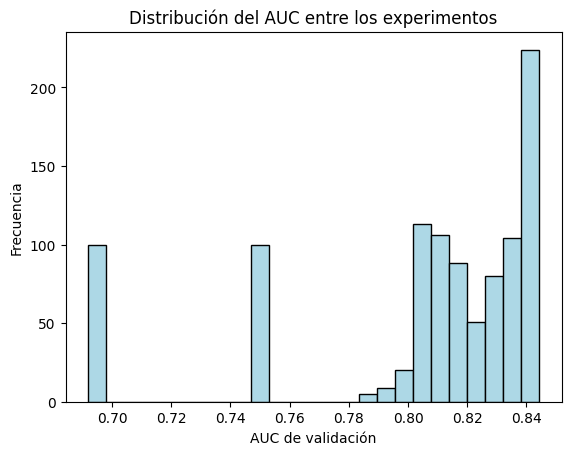

In [ ]:
#Vemos que la AUC varía significativamente entre los experimentos. Para visualizarlo, hagamos un gráfico

fig, ax = plt.subplots()
ax.hist(dtree_exp['auc_validation'], bins=25, color='lightblue', edgecolor='black')
ax.set_xlabel('AUC de validación')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución del AUC entre los experimentos')

plt.show()

In [ ]:
#Notamos que hay una diferencia de más de 15 puntos entre los valores de AUC, y que la mayoría de los experimentos dieron un AUC elevado (por ende, un mejor resultado).
#Vemos cual es el hiperparámetro más relevante

In [ ]:
#Básicamente vamos a iterar sobre los hiperparámetros y hacer estadística. Aclaramos en cada paso qué está haciendo

hiperpar = ['max_depth', 'min_samples_split', 'min_samples_leaf']
analisis_impacto = {}

for hp in hiperpar:
    #Calculamos el AUC de validación promedio
    prom_agrupados = dtree_exp.groupby(hp)['auc_validation'].mean()

    #Vemos la diferencia entre el max y el min. Vemos la STD
    rango_auc = prom_agrupados.max() - prom_agrupados.min()
    auc_std = prom_agrupados.std()

    analisis_impacto[hp] = {
        'rango_auc_promedio': rango_auc,
        'std_auc_promedio': auc_std}

#Lo emprolijamos
impact_df = pd.DataFrame.from_dict(analisis_impacto, orient='index')
impact_df = impact_df.sort_values(by='rango_auc_promedio', ascending=False)
print(impact_df)
print("\n Claramente max_depth es el más relevante!")

                   rango_auc_promedio  std_auc_promedio
max_depth                    0.150641          0.047654
min_samples_leaf             0.007853          0.003186
min_samples_split            0.001447          0.000569

 Claramente max_depth es el más relevante!


### Ejercicio 9
Para el modelo elegido en el punto anterior, identifique los umbrales de decisión (thresholds) que maximizan el valor de la métrica f1-score en validación (para ello van a tener que calcular las clases predichas al variar el umbral de decisión, utilizando las probabilidades predichas como input).

Pruebe con los valores de umbrales que surgen a partir de la siguiente expresión `np.arange(0.001, 0.999, 0.001)`. Realice un plot con los distintos resultados, poniendo los valores del threshold en el eje x y los valores del f1 score en el eje y. Dibuje con una línea punteada el valor máximo.

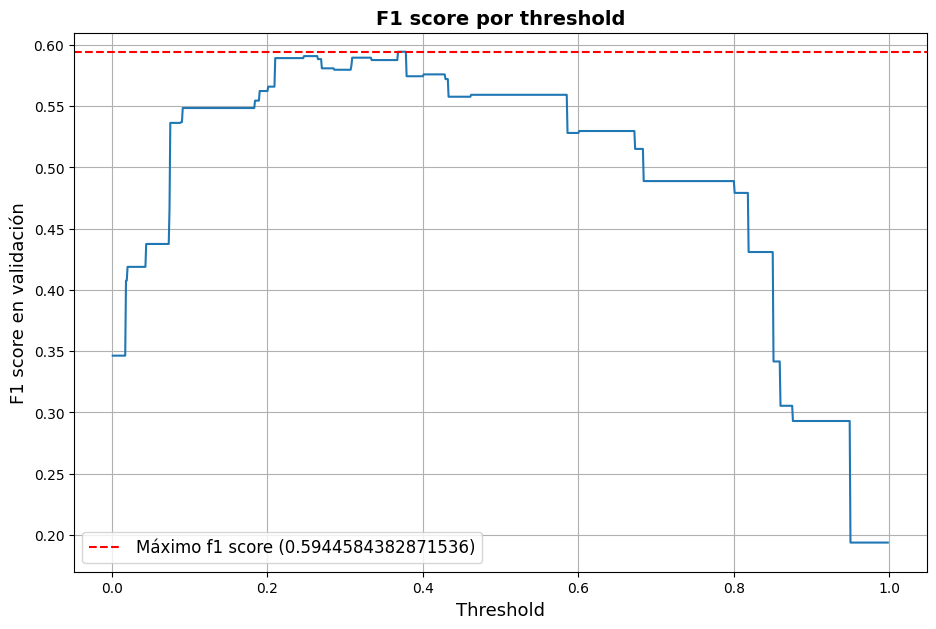

In [ ]:
modelo_elegido = DecisionTreeClassifier(**best_combination_hp_dtree, random_state=1234)
modelo_elegido.fit(X_train_procesado, y_train)
probabilidad = modelo_elegido.predict_proba(X_val_procesado)[:, 1]

from sklearn.metrics import f1_score

threshold_list = np.arange(0.001, 0.999, 0.001)
f1_scores = []

for threshold in threshold_list:
  y_pred = probabilidad >= threshold
  f1 = f1_score(y_val, y_pred)
  f1_scores.append(f1)

max_f1_score = max(f1_scores)

fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(threshold_list, f1_scores)
ax.set_title('F1 score por threshold', fontsize = 14, fontweight = 'bold')
ax.set_xlabel('Threshold', fontsize = 13)
ax.set_ylabel('F1 score en validación', fontsize = 13)
ax.axhline(y=max_f1_score, color='red', linestyle='--', label=f'Máximo f1 score ({max_f1_score})')
ax.set_ylim(0.17, 0.61)
ax.legend(fontsize = 12)
ax.grid()
plt.show()

In [ ]:
f1_scores.count(max_f1_score)

11

In [ ]:
#Observamos que hay 11 thresholds que maximizan el F1 score. Veamos cuáles son:

f1_scores = np.array(f1_scores)
indices = np.where(f1_scores == max_f1_score)[0]
mejores_thresholds = []
for i in indices:
  mejores_thresholds.append(float(threshold_list[i]))

print(f'Los thresholds que maximizan el F1 score son: {mejores_thresholds}')

Los thresholds que maximizan el F1 score son: [0.368, 0.369, 0.37, 0.371, 0.372, 0.373, 0.374, 0.375, 0.376, 0.377, 0.378]


### Ejercicio 10
¿Qué valores de precisión y recall arroja el modelo identificado en el punto anterior? (si fue más de un umbral el que maximiza F1 en el puntos anterior, elija el menor de los umbrales que encontró como solución de dicho punto).

Explique la relación entre precision, recall, F1 Score y AUC-ROC.

In [ ]:
from sklearn.metrics import precision_score, recall_score

threshold = min(mejores_thresholds)
y_pred2 = probabilidad >= threshold
precision = precision_score(y_val, y_pred2)
recall = recall_score(y_val, y_pred2)

print(f'El valor de precisión que arroja el modelo es {precision}, y el valor de recall es {recall}')


El valor de precisión que arroja el modelo es 0.7108433734939759, y el valor de recall es 0.5108225108225108


Tanto precision, recall, F1 Score como AUC-ROC son métricas de performance que surgen de hacer cálculos con los resultados de la matriz de confusión obtenida tras evaluar un modelo de clasificación. Recordemos que dicha matriz muestra cuántas instancias positivas o negativas fueron clasificadas correcta/incorrectamente por el modelo.

El valor de precision muestra qué tan confiables son las predicciones positivas: entre las predicciones positivas, cuántas son efectivamente positivas. El de recall indica cuántos de los verdaderos positivos son identificados por el modelo. Dependiendo del problema, conviene maximizar una u otra métrica. Por eso, si queremos un balance entre ambas métricas, es útil usar el F1 Score. Esta métrica combina las otras dos, calculando su media armónica (como explica Bramer en Principles of Data Mining).  

El problema de estas tres métricas es que dependen del threshold: el umbral de probabilidad a partir del cual el modelo predice una clase como positiva. Esto se ve claramente en el gráfico del ejercicio anterior. Mover el threshold hace que varien las métricas de performance, aunque el modelo prediga las mismas probabilidades. Por eso, para medir la performance del estimador sin depender del threshold podemos usar la métrica ROC, que muestra la relación entre la tasa de verdaderos y falsos positivos. Luego, para no tener que encontrar cuál es el máximo de la curva ROC, se toma el área bajo la curva (AUC-ROC) para hacer comparaciones, como venimos haciendo.

A continuación, ya que tenemos los valores de precision, recall, y F1 Score mostramos su relación en el ejemplo:



In [ ]:
#Empecemos haciendo la matriz de confusión para mostrar efectivamente de dónde vienen los valores de precision y recall:

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val, y_pred2)
print('Confusion matrix\n', conf_matrix)

TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

precision = TP / (TP + FP)
print('\nPrecision (TP / TP + FP):', precision)

recall = TP / (FN + TP)
print('\nRecall (TP / FN + TP):', recall)

F1_score = (2 * precision * recall) / (precision + recall)
print('\nF1 Score ((2 * precision * recall) / (precision + recall)):', F1_score)

print('\nAsí, mostramos que los valores de las métricas que calculamos utilizando la matriz de confusión son los mismos que los vistos anteriormente')

Confusion matrix
 [[821  48]
 [113 118]]

Precision (TP / TP + FP): 0.7108433734939759

Recall (TP / FN + TP): 0.5108225108225108

F1 Score ((2 * precision * recall) / (precision + recall)): 0.5944584382871536

Así, mostramos que los valores de las métricas que calculamos utilizando la matriz de confusión son los mismos que los vistos anteriormente


### Ejercicio 11

Entrene un árbol con los mejores hiperparámetros encontrados pero utilizando la suma de los datos de training y validation. NO deben escribir a mano el valor de los mejores hiperparámetros encontrados, deben aprovechar la estructura creada en el ejercicio 7.

Calcule cuál es el valor de AUC que obtiene en el test set en el árbol de decisión entrenado.

In [ ]:
#Para poder concatenar el x_train y x_val, quermos convertirlos a dfs para asegurarnos de que esté todo bien antes de entrenar al modelo.

columnas = preprocessor.get_feature_names_out()
columnas

array(['cat__Gender_Female', 'cat__Gender_Male', 'cat__Geography_France',
       'cat__Geography_Germany', 'cat__Geography_Spain',
       'num__CreditScore', 'num__Age', 'num__Tenure', 'num__Balance',
       'num__NumOfProducts', 'num__EstimatedSalary', 'num__HasCrCard',
       'num__IsActiveMember'], dtype=object)

In [ ]:
X_train_procesado_df = pd.DataFrame(X_train_procesado, columns=columnas)
X_val_procesado_df = pd.DataFrame(X_val_procesado, columns=columnas)
X_train_procesado_df.head(3)

,cat__Gender_Female,cat__Gender_Male,cat__Geography_France,cat__Geography_Germany,cat__Geography_Spain,num__CreditScore,num__Age,num__Tenure,num__Balance,num__NumOfProducts,num__EstimatedSalary,num__HasCrCard,num__IsActiveMember
0,1.0,0.0,1.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,93826.63,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,850.0,43.0,2.0,125510.82,1.0,79084.10,1.0,1.0
2,0.0,1.0,0.0,0.0,1.0,645.0,44.0,8.0,113755.78,2.0,149756.71,1.0,0.0


In [ ]:
X_train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71


In [ ]:
#Comprobamos que no se mezclaron los datos, ahora vamos a concatenar los dos dfs y armar nuestro nuevo set de train
X_train_val = pd.concat([X_train_procesado_df, X_val_procesado_df], axis = 0).reset_index(drop=True)

# También debemos combinar los sets de y
y_train_val = pd.concat([y_train, y_val]).reset_index(drop=True)
print(f"Tamaño del nuevo set de entrenamiento combinado (X): {X_train_val.shape}")
print(f"Tamaño del nuevo set de entrenamiento combinado (y): {y_train_val.shape}")

#Procesamos el x_test para convertir variables categóricas:
X_test = df_test.drop('Exited', axis=1)
y_test = df_test['Exited']
X_test_procesado = preprocessor.transform(X_test)
X_test_procesado_df = pd.DataFrame(X_test_procesado, columns=columnas)

#Entrenamos el modelo
modelo_elegido = DecisionTreeClassifier(**best_combination_hp_dtree, random_state=1234).fit(X_train_val, y_train_val)

#Vemos la performance en el test set
y_test_probabilidad = modelo_elegido.predict_proba(X_test_procesado_df)[:, 1]
auc_validation = roc_auc_score(y_test, y_test_probabilidad)
print(f'El valor AUC en el test set es: {auc_validation}')

Tamaño del nuevo set de entrenamiento combinado (X): (8900, 13)
Tamaño del nuevo set de entrenamiento combinado (y): (8900,)
El valor AUC en el test set es: 0.8419654714475432


### Ejercicio 12

Grafique el árbol obtenido en el ejercicio 11. Asegúrese de poder entender qué clase predice cada nodo y cuáles son los valores y variables que parten un nodo en dos.

Explique conceptualmente lo que está sucediendo y por qué ve lo que está viendo.

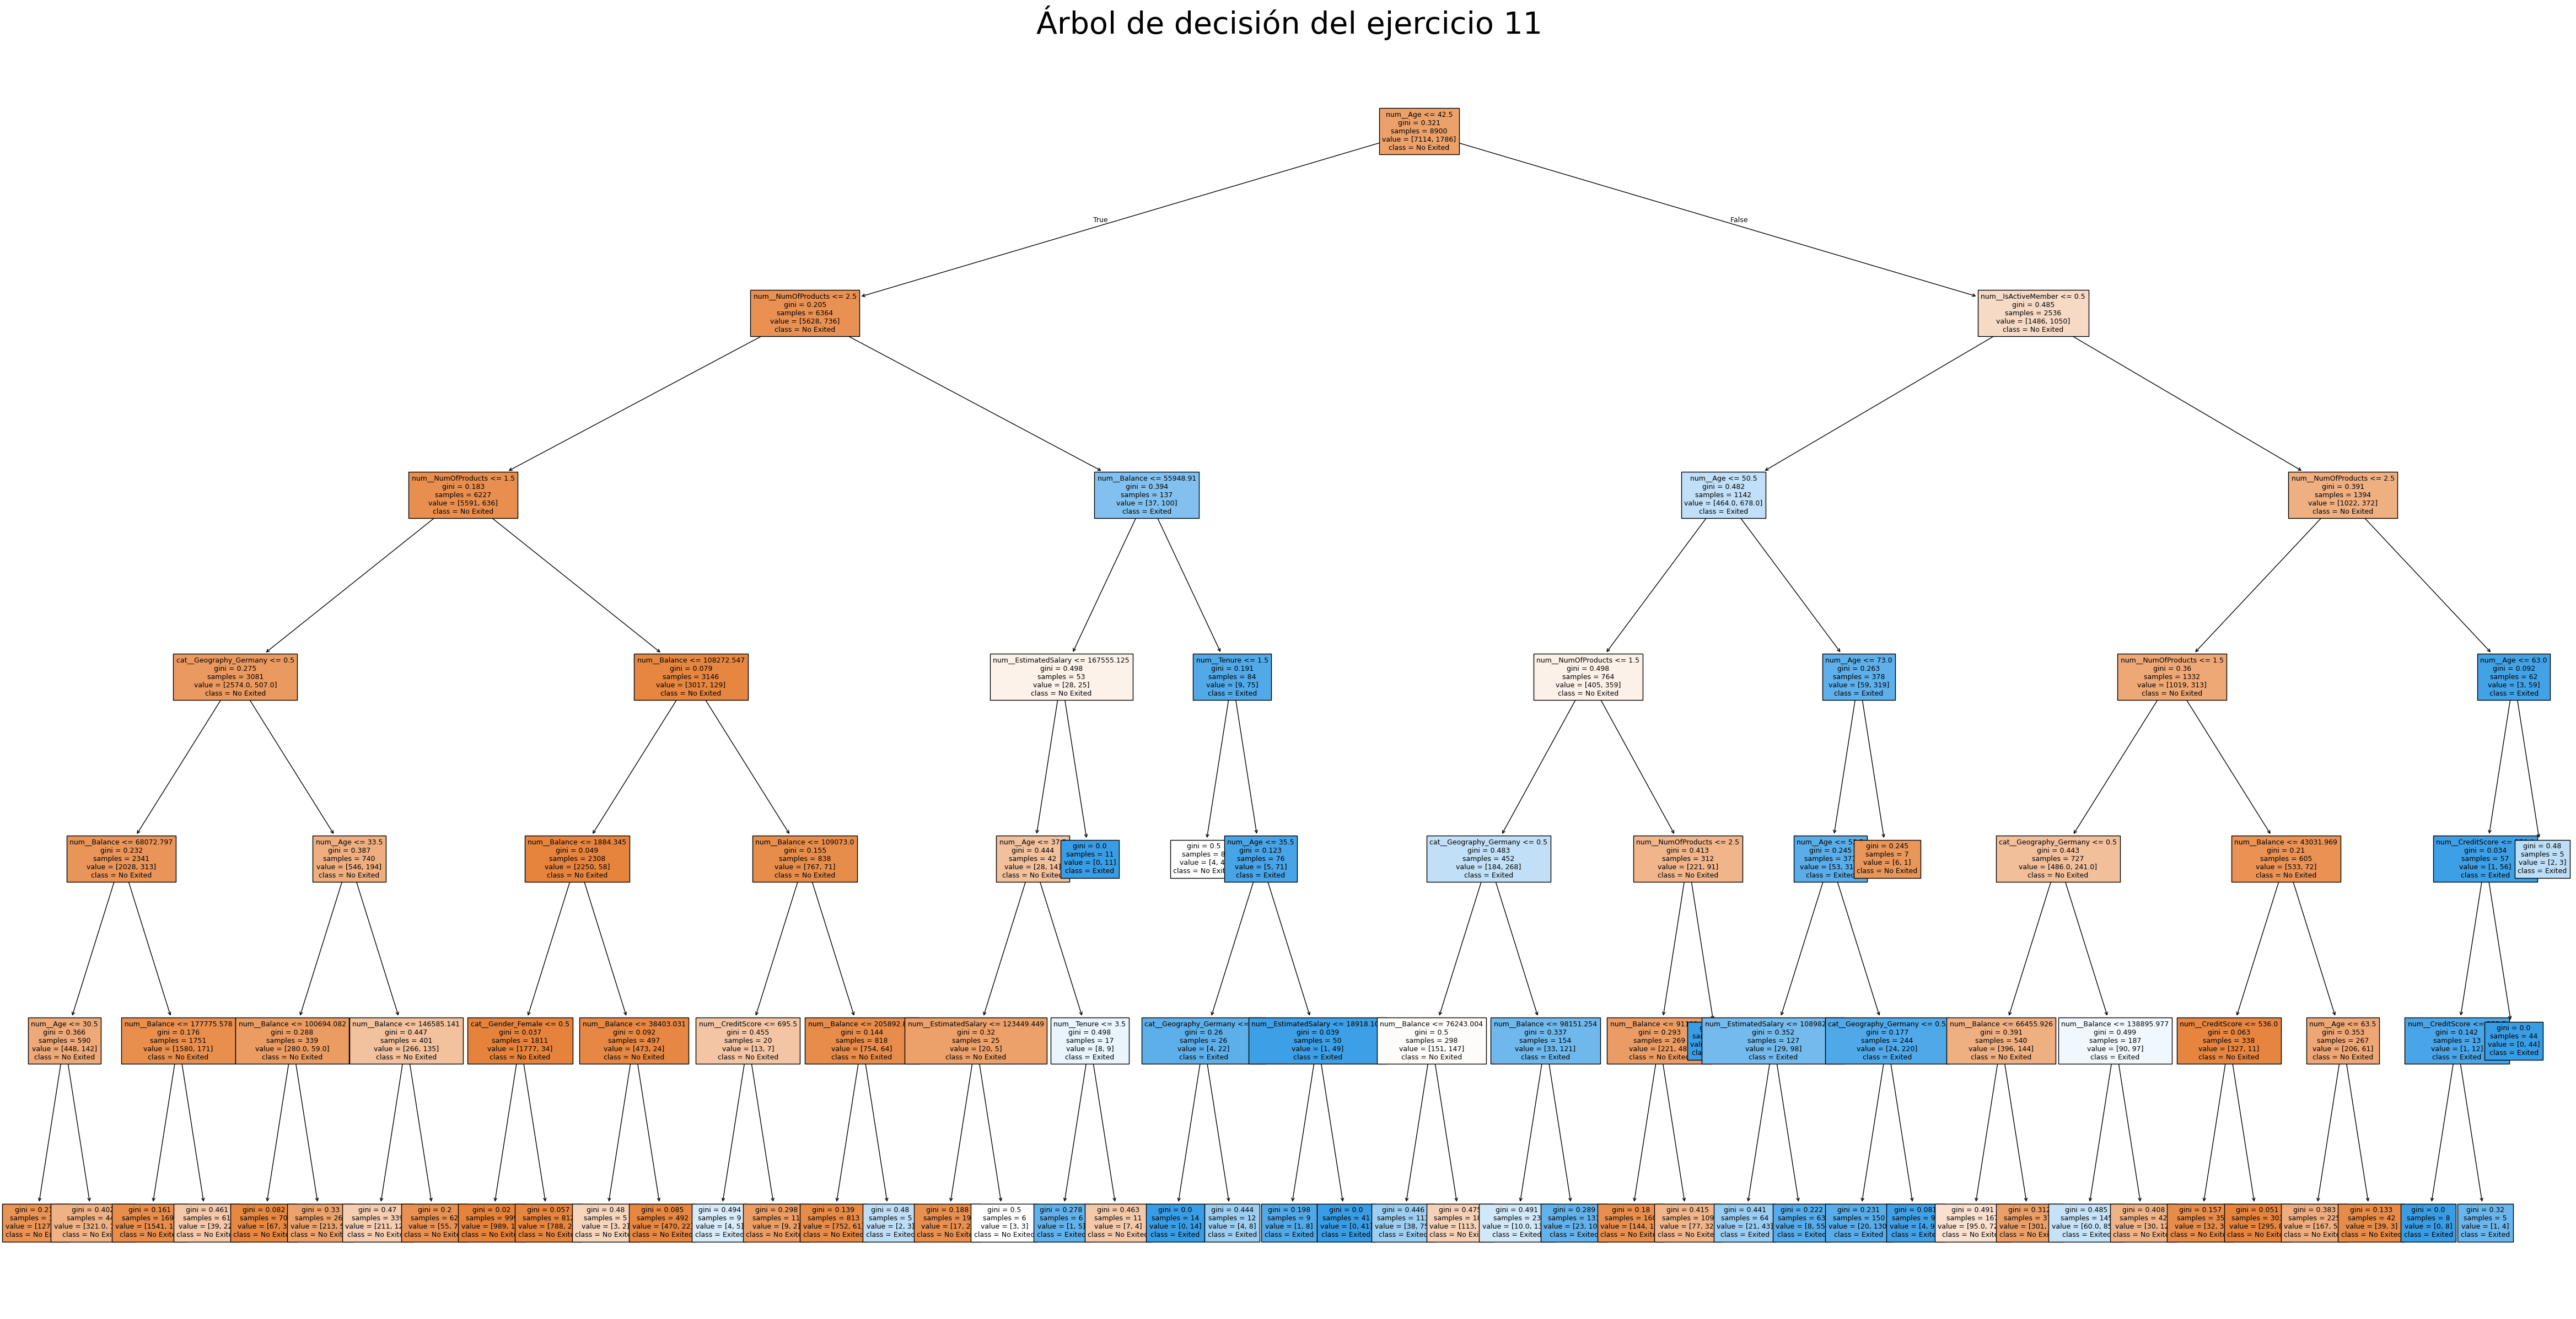

Es necesario agrandar la imagen, pero si la hacíamos más chica no se veía el texto de cada recuadro


In [ ]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(60, 30))
plot_tree(
    modelo_elegido,
    feature_names=columnas,
    class_names=["No Exited", "Exited"],
    filled=True,
    fontsize=9,
)
ax.set_title('Árbol de decisión del ejercicio 11', fontsize=40)
plt.show()

print('Es necesario agrandar la imagen, pero si la hacíamos más chica no se veía el texto de cada recuadro')

 Ahora analicemos lo que nos muestra este arbol, valiéndonos de la ayuda del libro _Hands on Machine Learning_.

 El algoritmo busca dividir el espacio de atributos en regiones cada vez más "puras" con respecto a la clase objetivo (en este caso, Exited / No Exited). Comienza considerando todas las observaciones disponibles (en este caso, 8.900, porque juntamos los datasets de train y validation) y realiza una primera división utilizando la variable Age con un umbral de 42.5 años. Elige esa feature y ese threshold porque son los que generan los subconjuntos más puros posibles en ese paso (aquellos con mayor predominancia de una sola clase). El modelo mide esta pureza mediante el índice de Gini y muestra, en cada nodo, la cantidad de observaciones de cada clase dentro del vector value (por ejemplo, en el nodo raíz hay 7.114 instancias de "No Exited" y 1.786 de "Exited"). En cada nodo hoja, el árbol predice la clase más frecuente entre las observaciones que caen en ese grupo (aunque la predicción final se obtiene del último nodo). En el gráfico se puede apreciar qué clase predice cada nodo y qué tan puro es mirando su color: los naranjas representan la clase No Exited, los azules Exited, y la intensidad indica el nivel de pureza.

 Luego de la primer división, el algoritmo vuelve a repetir el proceso hasta que:
  * alcanza la profundidad máxima que definimos de antemano (6 nodos)
  * no puede realizar una división que reduzca más la impureza
  * o alcanza el min_samples_split (mínimo número de observaciones que debe tener un nodo para que se lo pueda dividir) o el min_samples_leaf (mínimo número de observaciones que debe haber en cada hoja)

Así, por ejemplo, podemos ver que hay una rama que termina en el cuarto nodo y tiene un gini igual a 0, por lo cual no requiere de más divisiones para conseguir más pureza (ya tiene únicamente observaciones de la clase no exited). O, en otro caso, aunque el gini es de 0.48 hay sólo 5 observaciones, por lo cual no se puede volver a dividir.





### Ejercicio 13
Haga un gráfico con la importancia de atributos que se deriva del árbol obtenido en el ejercicio 10. ¿Cree que tiene sentido lo que se obtuvo?

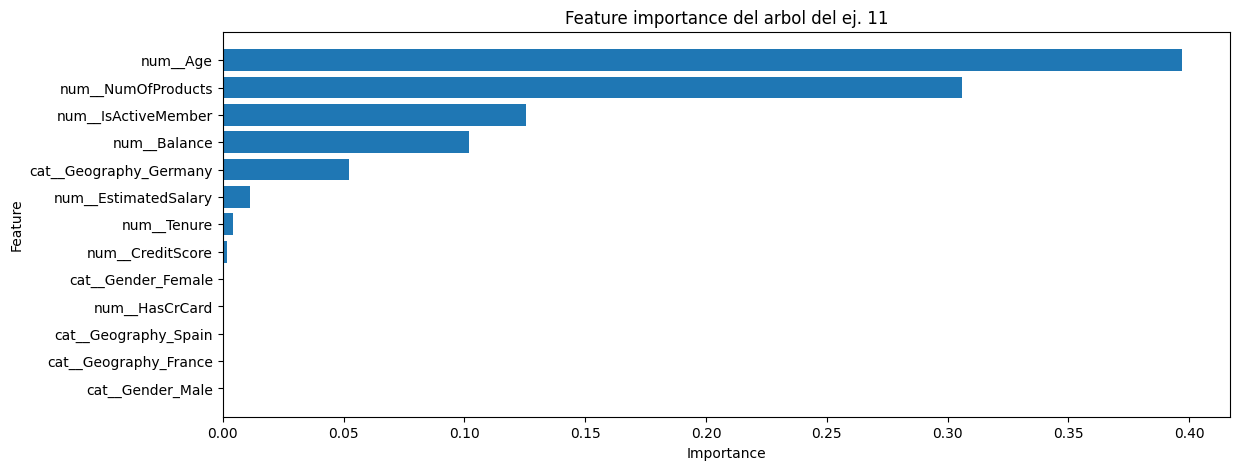

In [ ]:
feature_importance_df = pd.DataFrame({
    'feature': columnas,
    'importance': modelo_elegido.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(13, 5))
ax.barh(feature_importance_df['feature'], feature_importance_df['importance'])
ax.set_title('Feature importance del arbol del ej. 11')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
plt.show()

In [ ]:
#Intuitivamente tiene sentido que esas sean variables importantes. Lo clave es que el modelo le atribuye mucha importancia a una cantidad relativamente chica de variables.
#Esto tiene que ver con lo "greedy" que es el arbol a la hora de cortar ramas. El threshold para descartar cosas es bajo. Al final del trabajo explicamos mejor la diferencia.

### Ejercicio 14
Entrene un Random Forest sobre el dataset de entrenamiento `df_train` con los hiperparámetros default del modelo (solo con el train test, no con el train y validation juntos). ¿El modelo default tiene mejor performance que el modelo tuneado de árboles de decisión sobre el conjunto de test?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_default = RandomForestClassifier(random_state=1234)
rf_default.fit(X_train_procesado_df, y_train)

# Evalúo como venimos haciendo
y_prob_rf = rf_default.predict_proba(X_test_procesado_df)[:, 1]
auc_test_rf = roc_auc_score(y_test, y_prob_rf)

# Rrenombro la variable para no confundirme
auc_test_dt = auc_validation

# 3. Comparar la performance de ambos modelos
print(f"AUC del Árbol de Decisión tuneado en Test: {auc_test_dt:.4f}")
print(f"AUC del Random Forest (default) en Test: {auc_test_rf:.4f}\n")

print("Conclusión: Sí, el Random Forest con hiperparámetros default tiene una mejor performance que el árbol de decisión tuneado.")


AUC del Árbol de Decisión tuneado en Test: 0.8420
AUC del Random Forest (default) en Test: 0.8608

Conclusión: Sí, el Random Forest con hiperparámetros default tiene una mejor performance que el árbol de decisión tuneado.


### Ejercicio 15
Encuentre los mejores hiperparámetros para este modelo con una búsqueda aleatoria de 50 iteraciones, con un K fold CV de 5. Los rangos de cada hiperparámetro deberían ser:
- max_depth entre 1 y 10.
- min_samples_split entre 2 y 11,
- min_samples_leaf entre 1 y 10.  
- n_estimators entre 5 y 1000.

En total, debería tener 50 combinaciones de hiperparámetros posibles. Fije el random_state en el número 1234 para garantizar que los resultados son comparables.

En cada paso evalúe el AUC del conjunto de entrenamiento cross validado.

El resultado de este ejercicio debería ser un dataframe que se llame `rforest_exp` que tiene que tener las siguientes 7 columnas:
- n_estimators,
- max_depth,
- min_samples_split,
- min_samples_leaf,
- auc_training,
- auc_validation,
- experiment_id (`rforest_exp['experiment_id'] = [f'experiment_{i}' for i in range(len(rforest_exp))]`).


**Este dataframe debería tener 50 filas.**

Nota: puede utilizar la función de RandomSearchCV para resolver este ejercicio.

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

#Atención, este codigo es un misil balistico intercontinental de computo (termino tecnico), tardó 10 minutos la ultima vez que lo ejecuté. No está roto solo es lento.

#defino las cosas y una instancia del clasificador

dist_param = {
    'n_estimators': randint(5, 1001),
    'max_depth': randint(1, 11),
    'min_samples_split': randint(2, 12),
    'min_samples_leaf': randint(1, 11)
}

rf = RandomForestClassifier(random_state=1234)

#Configuro la busqueda

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=dist_param,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=1234,
    return_train_score=True,
    verbose =2 #Dana le puso esto que te dice qué esta haciendo mientras lo hace, sino parece que no anda
)

# random search
random_search.fit(X_train_procesado, y_train)

# creo el df y lo pongo lindo
resultados = random_search.cv_results_
rforest_exp = pd.DataFrame({
    'n_estimators': resultados['param_n_estimators'],
    'max_depth': resultados['param_max_depth'],
    'min_samples_split': resultados['param_min_samples_split'],
    'min_samples_leaf': resultados['param_min_samples_leaf'],
    'auc_training': resultados['mean_train_score'],
    'auc_validation': resultados['mean_test_score']
})

rforest_exp['experiment_id'] = [f'experiment_{i}' for i in range(len(rforest_exp))]
orden_columnas = [
    'experiment_id', 'n_estimators', 'max_depth', 'min_samples_split',
    'min_samples_leaf', 'auc_training', 'auc_validation'
]
rforest_exp = rforest_exp[orden_columnas]

print("Resultado de la búsqueda aleatoria de hiperparámetros para RF:")
print(f"Total de filas en el DF: {len(rforest_exp)}")
print(rforest_exp.head())


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Resultado de la búsqueda aleatoria de hiperparámetros para RF:
Total de filas en el DF: 50
  experiment_id  n_estimators  max_depth  min_samples_split  min_samples_leaf  \
0  experiment_0           209          4                  7                 7   
1  experiment_1           660          5                 11                 9   
2  experiment_2           159          2                 11                 8   
3  experiment_3           481          7                  2                 9   
4  experiment_4           388          6                 11                 1   

   auc_training  auc_validation  
0      0.851382        0.840187  
1      0.864982        0.848627  
2      0.824910        0.819208  
3      0.893619        0.856620  
4      0.878446        0.852968  


### Ejercicio 16

Seleccione el mejor conjunto de hiperparámetros (cree un diccionario, llamelo `best_combination_hp_rf`) y entrene un último modelo de Random Forest, juntando el dataset de train y de validation.

Evalúe su performance en test. ¿Es muy distinta de la obtenida del mejor modelo en el ejercicio anterior? ¿Por qué?

In [ ]:
#Creo best_comination_hp_rf

mejor_fila_rf = rforest_exp.loc[rforest_exp['auc_validation'].idxmax()]

best_combination_hp_rf = {
    'n_estimators': int(mejor_fila_rf['n_estimators']),
    'max_depth': int(mejor_fila_rf['max_depth']),
    'min_samples_split': int(mejor_fila_rf['min_samples_split']),
    'min_samples_leaf': int(mejor_fila_rf['min_samples_leaf'])
}
print("Mejores hiperparámetros:")
print(best_combination_hp_rf)


#Entreno el rf final

rf_final= RandomForestClassifier(random_state=1234, **best_combination_hp_rf)
rf_final.fit(X_train_val, y_train_val)
y_test_prob_rf = rf_final.predict_proba(X_test_procesado_df)[:, 1]
auc_test_rf = roc_auc_score(y_test, y_test_prob_rf)


#comparo

final_dt_model = DecisionTreeClassifier(random_state=1234, **best_combination_hp_dtree)
final_dt_model.fit(X_train_val, y_train_val)
y_test_prob_dt = final_dt_model.predict_proba(X_test_procesado_df)[:, 1]
auc_test_dt = roc_auc_score(y_test, y_test_prob_dt)

print("\n Resultados de Performance en el Test Set")
print(f"AUC del mejor Árbol de Decisión: {auc_test_dt:.4f}")
print(f"AUC del mejor Random Forest:     {auc_test_rf:.4f}")

Mejores hiperparámetros:
{'n_estimators': 622, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8}

 Resultados de Performance en el Test Set
AUC del mejor Árbol de Decisión: 0.8420
AUC del mejor Random Forest:     0.8738


### Ejercicio 17
Grafique el árbol 0 dentro del modelo de Random Forest que haya entrenado en el ejercicio 15.

Grafique la importancia de features a nivel agregado del Random Forest. ¿Es distinta al gráfico de importancia de features de árboles de decisión (ejercicio 12)? Justifique su respuesta.

GRAFICO DEL PRIMER ARBOL DEL RF


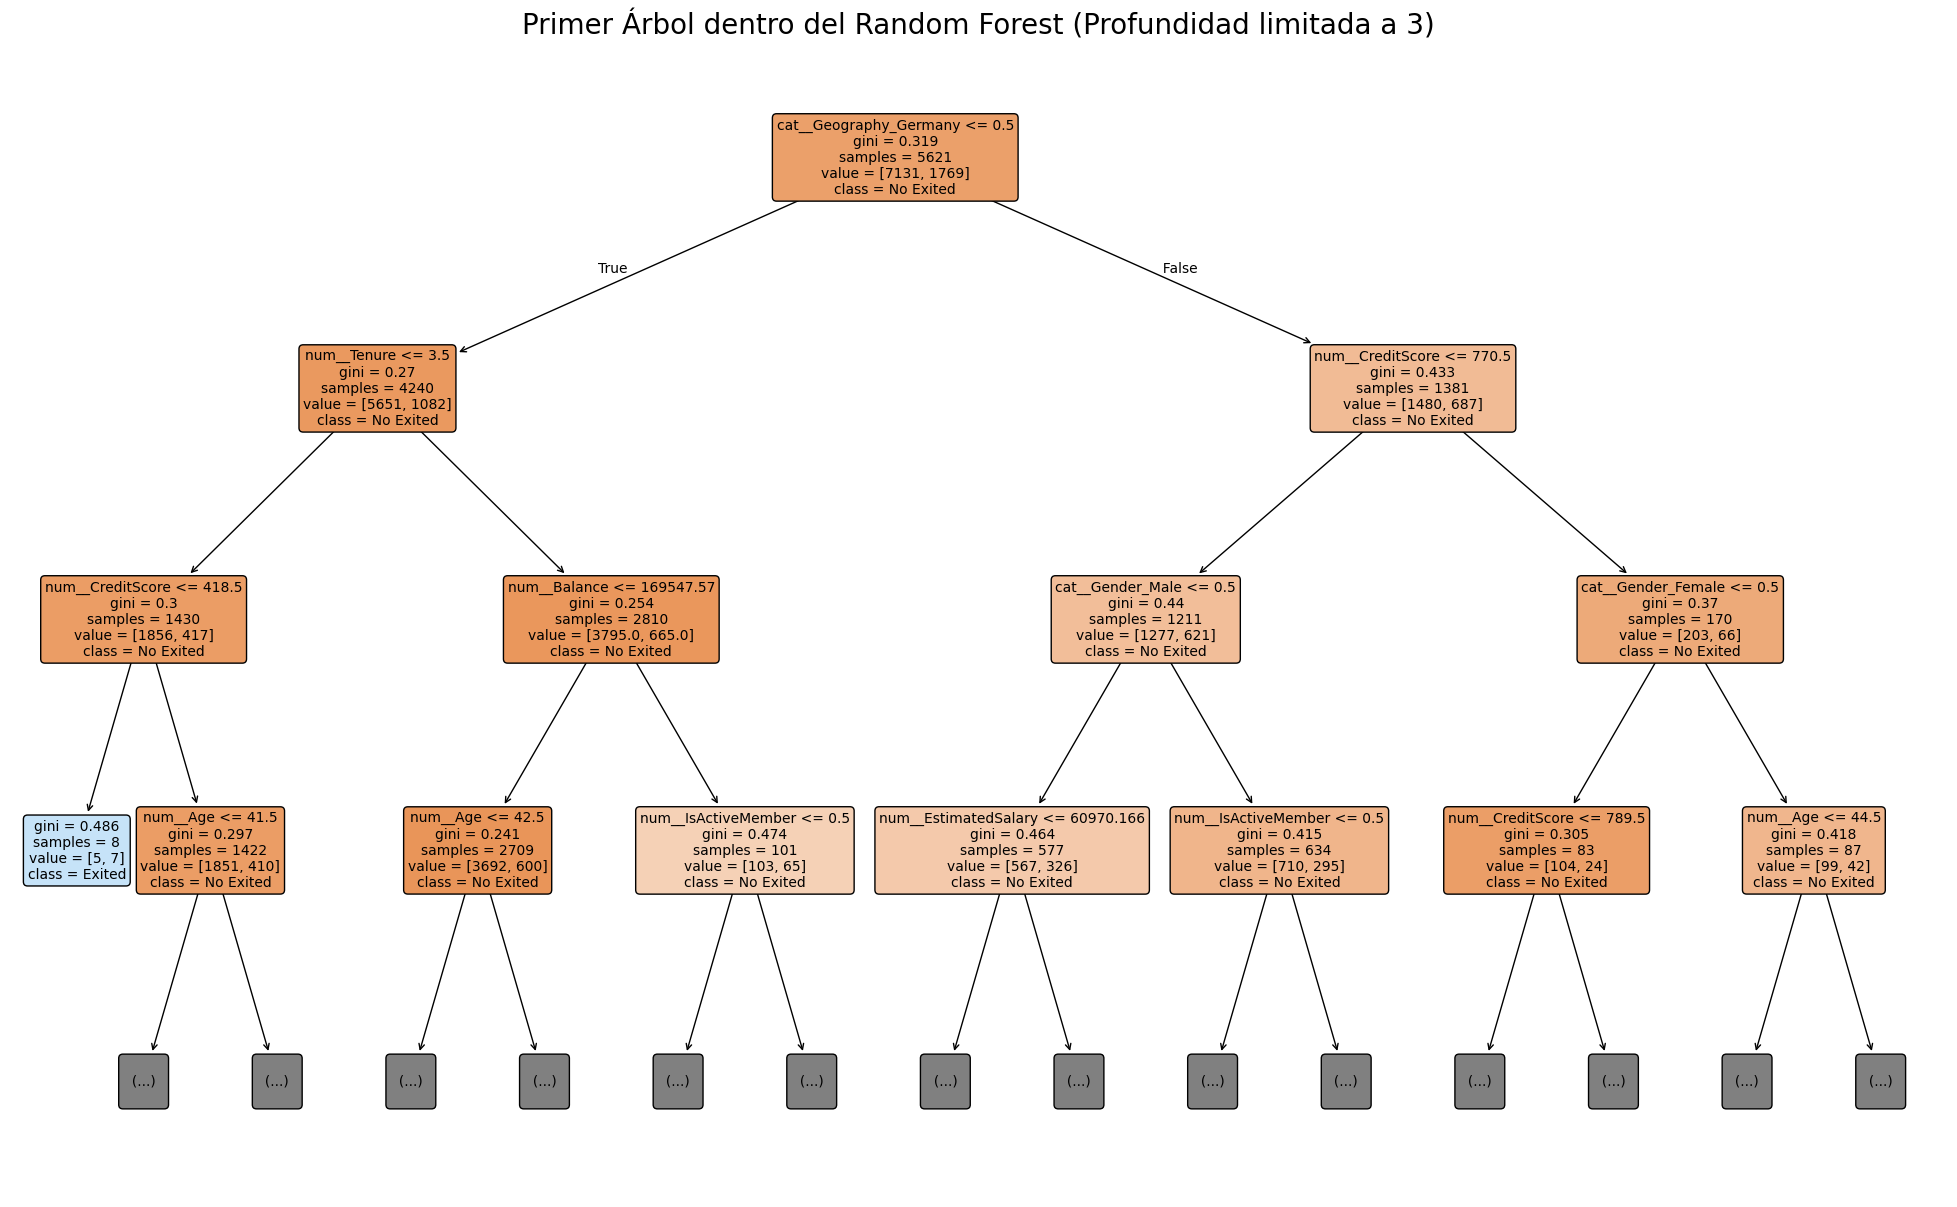

Gráfico guardado como 'arbol_rf_0.png'
Importancia de las features:


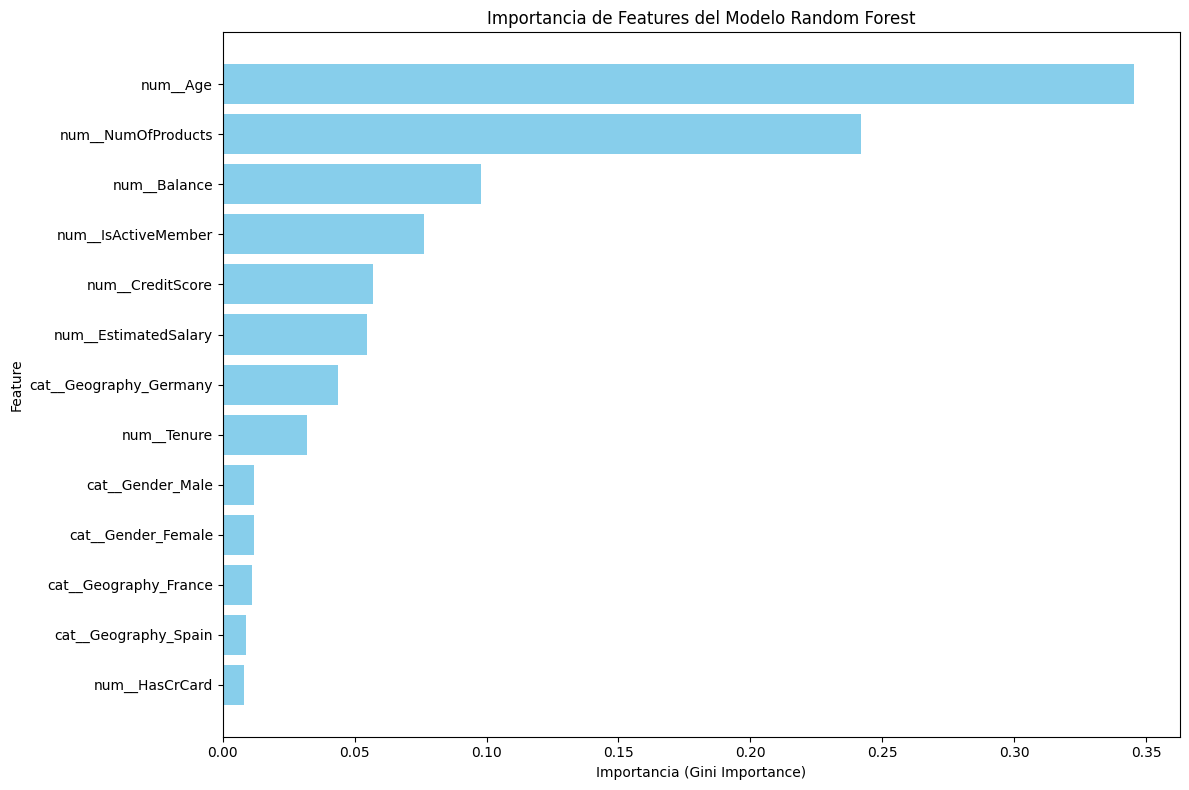

In [ ]:
# Parte 1: Graficar el primer árbol del Random Forest
print("GRAFICO DEL PRIMER ARBOL DEL RF")
plt.figure(figsize=(25, 15))

# Graficamos el primer árbol (índice 0) del ensamble.
# Nota: Se limita la profundidad a 3 niveles solo para la visualización, de lo contrario el árbol sería demasiado grande para ser legible.
plot_tree(rf_final.estimators_[0],
          feature_names= columnas,
          class_names=["No Exited", "Exited"],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)

plt.title("Primer Árbol dentro del Random Forest (Profundidad limitada a 3)", fontsize=20)
plt.savefig("arbol_rf_0.png")
plt.show()
print("Gráfico guardado como 'arbol_rf_0.png'")


#Features
print('Importancia de las features:')
rf_importance_df = pd.DataFrame({
    'feature': columnas,
    'importance': rf_final.feature_importances_
}).sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(rf_importance_df['feature'], rf_importance_df['importance'], color='skyblue')
plt.xlabel("Importancia (Gini Importance)")
plt.ylabel("Feature")
plt.title("Importancia de Features del Modelo Random Forest")
plt.tight_layout()
plt.savefig("importancia_features_rf.png")
plt.show()



In [ ]:
# Al final SI podemos hacer una comparación interesante. En el ejercicio 2 llegamos a la conclusión con un analisis univariado de que:

#    "HasCrCard no nos ayuda mucho a predecir el churn. Tenure y Estimated salary tampoco, por tener un p_value alto."
#
# Pero al final el análisis de relevancia de las features demostró que Tenure y Estimated Salary sí tenían algun valor, con EstimatedSalary siendo incluso más importante que una de las posibles ubicaciones geograficas.
# Intuitivamente esto tenía sentido y por eso las dejamos. Efectivamente el modelo parece haber encontrado relaciones específicas entre las variables que un análisis simple no.
# Por ejemplo, tendría sentido que si tu salario es alto, tu tenure es alta, sos de alemania, y sos hombre, etc, tengas muy pocas o muchas chances de irte.
# No podemos saberlo porque RF no es mecanisticamente interpretable. Es una caja negra. Sabemos que las ruedas son más importantes que las puertas para el funcionamiento del auto, pero no como el auto las combina para poder andar.

### Ejercicio 18
Responda la siguiente pregunta.

¿Por qué cree que el modelo de Random Forest trajo mejor performance que el modelo de árboles de decisión?


In [ ]:
#La razón principal por la que un Random Forest supera a un único Árbol de Decisión es que este último tiene muy alta varianza. Un árbol de decisión individual es muy inestable;
#pequeños cambios en los datos de entrenamiento pueden resultar en un árbol completamente diferente, lo que lo hace propenso a overfitting.

#Como dice ISLP, sección 8.2, pagina 343:

#The decision trees discussed in Section 8.1 suffer from high variance.
#This means that if we split the training data into two parts at random,
#and fit a decision tree to both halves, the results that we get could be
#quite different. In contrast, a procedure with low variance will yield similar
#results if applied repeatedly to distinct data sets; linear regression tends
#to have low variance, if the ratio of n to p is moderately large.


#Para combatir esto, Random Forest mejora el bagging. Al construir cada árbol, en cada división, solo se considera un subconjunto aleatorio de las variables predictoras.
#Esto "decorrelaciona" los árboles entre sí, haciendo que sean más diversos y reduce la varianza. Pag. 347:

#Random forests provide an improvement over bagged trees by way of a random
#small tweak that decorrelates the trees. As in bagging, we build a number forest
#of decision trees on bootstrapped training samples. But when building these
#decision trees, each time a split in a tree is considered, a random sample of
#m predictors is chosen as split candidates from the full set of p predictors.
#The split is allowed to use only one of those m predictors. [...] Then in the collection of bagged
#trees, most or all of the trees will use this strong predictor in the top split.
#Consequently, all of the bagged trees will look quite similar to each other. [...]
#Random forests overcome this problem by forcing each split to consider
#only a subset of the predictors. Therefore, on average (p − m)/p of the
#splits will not even consider the strong predictor, and so other predictors
#will have more of a chance. We can think of this process as decorrelating
#the trees, thereby making the average of the resulting trees less variable and hence more reliable.
#The main difference between bagging and random forests is the choice
#of predictor subset size m.

#El libro explica que promediar modelos que son menos similares entre sí conduce a una reducción de varianza aún mayor, lo que se traduce directamente en un mejor rendimiento predictivo.